In [1]:
import pandas as pd
import janitor
from IPython.display import display
from utilities import calculate_summary_statistics, pandas_to_tex
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style="white", context="notebook", font_scale=1.3)
from statsmodels.nonparametric.smoothers_lowess import lowess

from utilities import save_mpl_fig
from constants import var_labels, bl_measures, bl_measures_cumulative, bl_al1, bl_al10, palette7, linestyles7

Checking that all paths exist:
{'web_mobile': True, 'web_desktop': True, 'web': True, 'yg_profile': True, 'blacklight': True, 'who': True}


## Prep data

In [2]:
age_order = ["<25", "25-34", "35-49", "50-64", "65+"]

df = pd.read_csv("../data/combined_yg_bl_who.csv").assign(
    agegroup_lab=lambda df_: pd.Categorical(
        df_["agegroup_lab"], categories=age_order, ordered=True
    )
)
display(df.head())
df.info(verbose=True)

,caseid,tt_visits,tt_domains,bl_ddg_join_ads,bl_third_party_cookies,bl_canvas_fingerprinting,bl_session_recording,bl_key_logging,bl_fb_pixel,bl_google_analytics,...,who_social_media_rate,who_social_media_al1,who_social_media_al3,who_social_media_al5,who_social_media_al10,who_adult_advertising_rate,who_adult_advertising_al1,who_adult_advertising_al3,who_adult_advertising_al5,who_adult_advertising_al10
0,47541,17194,553,3107.0,4238.0,44.0,51.0,23.0,90.0,9.0,...,0.546702,True,True,True,True,0.0,False,False,False,False
1,56565,11479,334,1606.0,2193.0,18.0,16.0,11.0,44.0,5.0,...,0.644655,True,True,True,True,0.0,False,False,False,False
2,203271,6540,152,308.0,514.0,6.0,10.0,1.0,7.0,1.0,...,0.489297,True,True,True,True,0.0,False,False,False,False
3,216457,1770,49,146.0,234.0,7.0,4.0,1.0,4.0,1.0,...,0.790960,True,True,True,True,0.0,False,False,False,False
4,257495,10012,284,874.0,1149.0,21.0,15.0,10.0,29.0,5.0,...,0.589293,True,True,True,True,0.0,False,False,False,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1134 entries, 0 to 1133
Data columns (total 142 columns):
 #    Column                                    Dtype   
---   ------                                    -----   
 0    caseid                                    int64   
 1    tt_visits                                 int64   
 2    tt_domains                                int64   
 3    bl_ddg_join_ads                           float64 
 4    bl_third_party_cookies                    float64 
 5    bl_canvas_fingerprinting                  float64 
 6    bl_session_recording                      float64 
 7    bl_key_logging                            float64 
 8    bl_fb_pixel                               float64 
 9    bl_google_analytics                       float64 
 10   who_adult_advertising                     float64 
 11   who_advertising                           float64 
 12   who_audio_video_player                    float64 
 13   who_consent_management         

In [3]:
# 2 caseid has no tracking data at all
df.query("bl_third_party_cookies!=bl_third_party_cookies")

,caseid,tt_visits,tt_domains,bl_ddg_join_ads,bl_third_party_cookies,bl_canvas_fingerprinting,bl_session_recording,bl_key_logging,bl_fb_pixel,bl_google_analytics,...,who_social_media_rate,who_social_media_al1,who_social_media_al3,who_social_media_al5,who_social_media_al10,who_adult_advertising_rate,who_adult_advertising_al1,who_adult_advertising_al3,who_adult_advertising_al5,who_adult_advertising_al10
585,233892273,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,False,False,False,False,NaN,False,False,False,False
863,292286781,13,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,False,False,False,False,NaN,False,False,False,False


In [4]:
df = df.dropna(
    subset=[
        "bl_ddg_join_ads",
        "bl_third_party_cookies",
        "bl_canvas_fingerprinting",
        "bl_session_recording",
        "bl_key_logging",
        "bl_fb_pixel",
        "bl_google_analytics",
        "who_adult_advertising",
        "who_advertising",
        "who_audio_video_player",
        "who_consent_management",
        "who_customer_interaction",
        "who_data_saved",
        "who_hosting",
        "who_misc",
        "who_site_analytics",
        "who_social_media",
        "who_trackers_per_page_load",
        "who_trackers_requests_all_requests",
        "who_tracking_requests_per_page_load",
        "who_utilities",
        "bl_ddg_join_ads_rate",
        "bl_third_party_cookies_rate",
        "bl_canvas_fingerprinting_rate",
        "bl_session_recording_rate",
        "bl_key_logging_rate",
        "bl_fb_pixel_rate",
        "bl_google_analytics_rate",
        "who_trackers_per_page_load_rate",
        "who_tracking_requests_per_page_load_rate",
        "who_trackers_requests_all_requests_rate",
        "who_data_saved_rate",
        "who_advertising_rate",
        "who_audio_video_player_rate",
        "who_customer_interaction_rate",
        "who_hosting_rate",
        "who_consent_management_rate",
        "who_site_analytics_rate",
        "who_misc_rate",
        "who_utilities_rate",
        "who_social_media_rate",
        "who_adult_advertising_rate",
    ],
    how="all",
)
df

,caseid,tt_visits,tt_domains,bl_ddg_join_ads,bl_third_party_cookies,bl_canvas_fingerprinting,bl_session_recording,bl_key_logging,bl_fb_pixel,bl_google_analytics,...,who_social_media_rate,who_social_media_al1,who_social_media_al3,who_social_media_al5,who_social_media_al10,who_adult_advertising_rate,who_adult_advertising_al1,who_adult_advertising_al3,who_adult_advertising_al5,who_adult_advertising_al10
0,47541,17194,553,3107.0,4238.0,44.0,51.0,23.0,90.0,9.0,...,0.546702,True,True,True,True,0.000000,False,False,False,False
1,56565,11479,334,1606.0,2193.0,18.0,16.0,11.0,44.0,5.0,...,0.644655,True,True,True,True,0.000000,False,False,False,False
2,203271,6540,152,308.0,514.0,6.0,10.0,1.0,7.0,1.0,...,0.489297,True,True,True,True,0.000000,False,False,False,False
3,216457,1770,49,146.0,234.0,7.0,4.0,1.0,4.0,1.0,...,0.790960,True,True,True,True,0.000000,False,False,False,False
4,257495,10012,284,874.0,1149.0,21.0,15.0,10.0,29.0,5.0,...,0.589293,True,True,True,True,0.000000,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,342376013,5573,108,916.0,1205.0,11.0,4.0,1.0,12.0,2.0,...,1.256056,True,True,True,True,0.000000,False,False,False,False
1130,342383477,869,39,147.0,58.0,3.0,3.0,1.0,6.0,0.0,...,1.380898,True,True,True,True,0.000000,False,False,False,False
1131,343144813,839,25,5.0,7.0,0.0,0.0,0.0,0.0,0.0,...,0.119190,True,False,False,False,0.000000,False,False,False,False
1132,343195461,529,34,172.0,133.0,2.0,2.0,0.0,4.0,0.0,...,1.890359,True,True,True,True,0.567108,True,True,False,False


In [5]:
df["tt_visits"].describe()

count     1132.000000
mean      5509.557420
std       8251.136843
min          2.000000
25%        757.500000
50%       2551.000000
75%       7152.750000
max      86659.000000
Name: tt_visits, dtype: float64

In [6]:
df["tt_domains"].describe()

count    1132.000000
mean      164.660777
std       153.295839
min         1.000000
25%        54.000000
50%       123.000000
75%       220.000000
max      1009.000000
Name: tt_domains, dtype: float64

## BL

### Exposure rate

In [7]:
# exposure rate
df_bl_summ_exposure_rate = (
    df.select_columns(bl_measures)
    .describe(percentiles=[0.25, 0.5, 0.75])
    # =====================================================
    # Tidy table and Fromat numbers
    .T.reset_index(names="var")
    #     .assign(count=lambda df_: df_["count"].apply(lambda x: f"{int(x):,}"))
    .remove_columns("count")
    .applymap(lambda x: f"{x:,.1f}" if isinstance(x, (float, int)) else x)
    .replace("_rate", "", regex=True)
    # =====================================================
    .assign(var=lambda df_: df_["var"].replace(var_labels))
)
pandas_to_tex(
    df_bl_summ_exposure_rate, "../tables/individual_blacklight_exposure_rate_summary"
)
df_bl_summ_exposure_rate

,var,mean,std,min,25%,50%,75%,max
0,Ad Trackers,41.4,66.1,0.0,11.8,21.3,46.0,921.4
1,Third-Party Cookies,57.7,110.8,0.0,14.7,27.2,58.7,"2,192.9"
2,Facebook Pixel,0.8,1.1,0.0,0.2,0.5,1.0,14.8
3,Google Analytics,0.1,0.2,0.0,0.0,0.0,0.1,4.8
4,Session Recording,0.4,0.6,0.0,0.1,0.2,0.4,10.0
5,Keylogging,0.2,0.4,0.0,0.0,0.1,0.2,8.3
6,Canvas Fingerprinting,0.4,0.8,0.0,0.1,0.2,0.5,12.5


In [8]:
!cat ../tables/individual_blacklight_exposure_rate_summary.tex

Ad Trackers & 41.4 & 66.1 & 0.0 & 11.8 & 21.3 & 46.0 & 921.4 \\
Third-Party Cookies & 57.7 & 110.8 & 0.0 & 14.7 & 27.2 & 58.7 & 2,192.9 \\
Facebook Pixel & 0.8 & 1.1 & 0.0 & 0.2 & 0.5 & 1.0 & 14.8 \\
Google Analytics & 0.1 & 0.2 & 0.0 & 0.0 & 0.0 & 0.1 & 4.8 \\
Session Recording & 0.4 & 0.6 & 0.0 & 0.1 & 0.2 & 0.4 & 10.0 \\
Keylogging & 0.2 & 0.4 & 0.0 & 0.0 & 0.1 & 0.2 & 8.3 \\
Canvas Fingerprinting & 0.4 & 0.8 & 0.0 & 0.1 & 0.2 & 0.5 & 12.5 \\

### Cumulative

In [9]:
# cumulative exposure
df_bl_summ_cum_exposure = (
    df.select_columns(bl_measures_cumulative)
    .describe(percentiles=[0.25, 0.5, 0.75])
    # =====================================================
    # Tidy table and Fromat numbers
    .T.reset_index(names="var")
    .remove_columns("count")
    .applymap(lambda x: f"{x:,.0f}" if isinstance(x, (float, int)) else x)
    # =====================================================
    # Get at least one
    .merge(
        (
            df.select_columns(bl_al1)
            .mean()
            .multiply(100)
            .round(1)
            .astype(str)
            .add("\%")
            .reset_index(name="atleast1")
            .rename_column("index", "var")
            .replace("_al1", "", regex=True)
        ),
        how="left",
        on="var",
        validate="1:1",
    )
    # =====================================================
    # Get at least ten
    .merge(
        (
            df.select_columns(bl_al10)
            .mean()
            .multiply(100)
            .round(1)
            .astype(str)
            .add("\%")
            .reset_index(name="atleast10")
            .rename_column("index", "var")
            .replace("_al10", "", regex=True)
        ),
        how="left",
        on="var",
        validate="1:1",
    )
    .assign(var=lambda df_: df_["var"].replace(var_labels))
)
pandas_to_tex(
    df_bl_summ_cum_exposure,
    "../tables/individual_blacklight_cumulative_exposure_summary",
)
df_bl_summ_cum_exposure

,var,mean,std,min,25%,50%,75%,max,atleast1,atleast10
0,Ad Trackers,793,750,0,254,578,"1,077","5,137",99.7\%,97.3\%
1,Third-Party Cookies,"1,064","1,030",0,322,744,"1,458","7,003",99.6\%,98.0\%
2,Facebook Pixel,19,20,0,5,14,26,200,94.9\%,63.3\%
3,Google Analytics,3,4,0,0,2,4,39,72.5\%,5.1\%
4,Session Recording,9,10,0,2,6,12,93,89.8\%,35.9\%
5,Keylogging,4,5,0,1,3,6,37,85.1\%,12.6\%
6,Canvas Fingerprinting,9,9,0,3,7,13,76,91.9\%,37.8\%


## WTM

### Exposure rate

In [10]:
wtm_measures = [
    #     "who_tracking_requests_per_page_load_rate",
    "who_trackers_per_page_load_rate",
]

In [11]:
# exposure rate
df_who_summ_exposure_rate = (
    df.select_columns(wtm_measures)
    .describe(percentiles=[0.25, 0.5, 0.75])
    # =====================================================
    # Tidy table and Fromat numbers
    .T.reset_index(names="var")
    #     .assign(count=lambda df_: df_["count"].apply(lambda x: f"{int(x):,}"))
    .remove_columns("count")
    .round(1)
    .applymap(lambda x: f"{x:,.1f}" if isinstance(x, (float, int)) else x)
    .replace("_rate", "", regex=True)
    # =====================================================
    .assign(var=lambda df_: df_["var"].replace(var_labels))
)
pandas_to_tex(
    df_who_summ_exposure_rate, "../tables/individual_who_exposure_rate_summary"
)
df_who_summ_exposure_rate

,var,mean,std,min,25%,50%,75%,max
0,Trackers/Page Load,22.1,31.4,0.1,6.3,11.8,24.2,352.6


### Cumulative

In [12]:
wtm_measures_cum = [
    #     "who_tracking_requests_per_page_load",
    "who_trackers_per_page_load",
]

In [13]:
# cumulative exposure
df_who_summ_cum_exposure = (
    df.select_columns(wtm_measures_cum)
    .describe(percentiles=[0.25, 0.5, 0.75])
    # =====================================================
    # Tidy table and Fromat numbers
    .T.reset_index(names="var")
    .remove_columns("count")
    .applymap(lambda x: f"{x:,.0f}" if isinstance(x, (float, int)) else x)
    # =====================================================
    # Get at least one
    .merge(
        (
            df.select_columns(
                [
                    "who_tracking_requests_per_page_load_al1",
                    "who_trackers_per_page_load_al1",
                ]
            )
            .mean()
            .multiply(100)
            .round(1)
            .astype(str)
            .add("\%")
            .reset_index(name="atleast1")
            .rename_column("index", "var")
            .replace("_al1", "", regex=True)
        ),
        how="left",
        on="var",
        validate="1:1",
    )
    # =====================================================
    # Get at least ten
    .merge(
        (
            df.select_columns(
                [
                    "who_tracking_requests_per_page_load_al10",
                    "who_trackers_per_page_load_al10",
                ]
            )
            .mean()
            .multiply(100)
            .round(1)
            .astype(str)
            .add("\%")
            .reset_index(name="atleast10")
            .rename_column("index", "var")
            .replace("_al10", "", regex=True)
        ),
        how="left",
        on="var",
        validate="1:1",
    )
    .assign(var=lambda df_: df_["var"].replace(var_labels))
)
pandas_to_tex(
    df_who_summ_cum_exposure, "../tables/individual_who_cumulative_exposure_summary"
)
df_who_summ_cum_exposure

,var,mean,std,min,25%,50%,75%,max,atleast1,atleast10
0,Trackers/Page Load,387,339,2,145,305,529,"2,343",100.0\%,98.1\%


## Summ by demo

In [14]:
percentiles = [5, 10, 25, 50, 75, 90, 95]

In [15]:
demo_group = ["gender_lab", "race_lab", "educ_lab", "agegroup_lab"]

In [16]:
results = []
for measure in ["tt_visits", "tt_domains"]:
    for demo in demo_group:
        summary_df = calculate_summary_statistics(
            df,
            groupby_column=demo,
            value_column=measure,
            percentiles=percentiles,
        ).assign(tracker_measure=measure)

        if demo == "agegroup_lab":
            summary_df = summary_df.sort_values(by=demo)

        display(summary_df)
        results.append(summary_df)

,gender_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
0,Female,595 (52.6\%),5091.6,7177.6,2,71.4,202.2,730.5,2306.0,6496.0,14326.8,19119.8,48510,tt_visits
1,Male,537 (47.4\%),5972.6,9282.0,3,68.6,168.4,817.0,2789.0,7633.0,14445.6,21283.6,86659,tt_visits


,race_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
0,White,719 (63.5\%),5787.7,8175.3,2,78.0,230.6,839.0,2789.0,7543.0,15446.2,20744.8,79210,tt_visits
1,Hispanic,168 (14.8\%),4490.5,8565.4,2,40.0,154.0,497.0,1592.0,5030.2,11893.2,14469.2,86659,tt_visits
2,Black,144 (12.7\%),4867.1,8163.6,3,64.5,141.5,702.2,1917.0,4973.2,12547.7,19378.8,46415,tt_visits
3,Other,56 (4.9\%),5130.5,6654.8,11,41.2,104.5,598.2,1978.0,7793.0,12734.0,16323.8,29292,tt_visits
4,Asian,45 (4.0\%),7397.4,9926.5,6,65.6,259.6,1144.0,4059.0,11061.0,16239.6,18633.2,54986,tt_visits


,educ_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
0,HS or Below,409 (36.1\%),4714.1,7452.3,2,54.0,142.4,532.0,1754.0,5551.0,12956.0,19028.4,79210,tt_visits
1,Some college,326 (28.8\%),5140.9,7423.7,2,99.5,235.5,860.0,2361.5,6691.2,12498.5,18998.2,53193,tt_visits
2,College,255 (22.5\%),6755.0,9919.7,4,142.5,306.0,965.5,3130.0,9130.5,17455.8,22187.5,86659,tt_visits
3,Postgrad,142 (12.5\%),6410.6,8679.3,5,39.2,134.5,1080.0,3674.0,7634.2,15118.4,21316.8,53725,tt_visits


,agegroup_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
4,<25,93 (8.2\%),3629.6,6153.1,12,45.8,135.2,501.0,1355.0,3834.0,9295.0,13405.0,41350,tt_visits
3,25-34,198 (17.5\%),4986.1,10365.0,2,43.1,192.2,799.2,1692.0,4490.8,12148.7,17948.2,86659,tt_visits
1,35-49,285 (25.2\%),4542.1,6936.8,2,56.2,114.2,535.0,1856.0,5432.0,12973.4,17802.4,53725,tt_visits
0,50-64,288 (25.4\%),5962.6,7998.4,16,94.5,249.1,861.0,2781.5,8213.8,14923.7,20281.6,53193,tt_visits
2,65+,268 (23.7\%),7090.6,8423.9,5,156.1,366.1,1352.8,4041.0,9510.8,18255.2,22252.7,48510,tt_visits


,gender_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
0,Female,595 (52.6\%),166.8,153.6,1,11.0,24.0,57.5,125.0,219.5,348.4,474.9,1009,tt_domains
1,Male,537 (47.4\%),162.2,153.1,1,11.0,20.0,49.0,114.0,221.0,375.4,468.0,956,tt_domains


,race_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
0,White,719 (63.5\%),172.1,156.9,1,14.9,25.0,55.0,125.0,234.5,372.2,504.2,928,tt_domains
1,Hispanic,168 (14.8\%),143.5,125.1,1,6.0,15.7,48.0,106.5,210.2,288.7,403.4,797,tt_domains
2,Black,144 (12.7\%),155.3,176.9,2,8.2,18.3,47.2,108.5,183.2,329.4,471.0,1009,tt_domains
3,Other,56 (4.9\%),151.5,127.6,4,7.8,14.5,48.2,136.5,216.5,320.5,363.2,671,tt_domains
4,Asian,45 (4.0\%),171.2,132.8,2,7.4,25.4,66.0,156.0,228.0,399.2,422.8,505,tt_domains


,educ_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
0,HS or Below,409 (36.1\%),145.9,141.1,1,9.0,18.0,44.0,108.0,196.0,329.2,418.0,891,tt_domains
1,Some college,326 (28.8\%),162.8,148.2,1,12.2,21.0,60.2,120.5,222.0,345.0,442.5,956,tt_domains
2,College,255 (22.5\%),187.7,171.7,1,17.7,28.0,61.0,138.0,271.5,388.8,518.2,1009,tt_domains
3,Postgrad,142 (12.5\%),181.6,157.8,1,4.1,15.4,79.8,151.0,219.0,422.2,481.8,879,tt_domains


,agegroup_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
4,<25,93 (8.2\%),120.7,142.5,3,5.6,12.0,37.0,74.0,150.0,254.8,419.2,956,tt_domains
3,25-34,198 (17.5\%),131.8,120.2,1,7.7,19.0,45.2,96.5,180.8,271.9,381.6,797,tt_domains
1,35-49,285 (25.2\%),146.2,137.8,1,6.4,17.0,45.0,113.0,198.0,299.6,375.4,1009,tt_domains
0,50-64,288 (25.4\%),179.0,153.3,4,17.4,29.0,67.5,135.0,239.0,381.4,483.5,930,tt_domains
2,65+,268 (23.7\%),208.5,180.1,1,15.7,28.0,76.8,158.5,287.0,438.2,552.6,928,tt_domains


In [17]:
results = []
for measure in bl_measures:
    for demo in demo_group:
        summary_df = calculate_summary_statistics(
            df,
            groupby_column=demo,
            value_column=measure,
            percentiles=percentiles,
        ).assign(tracker_measure=measure)

        if demo == "agegroup_lab":
            summary_df = summary_df.sort_values(by=demo)

        display(summary_df)
        results.append(summary_df)

,gender_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
0,Female,595 (52.6\%),41.9,55.5,0.0,5.2,7.6,12.9,22.8,53.0,94.3,128.6,561.9,bl_ddg_join_ads_rate
1,Male,537 (47.4\%),40.8,76.3,0.0,4.4,6.2,10.5,19.9,39.8,89.3,136.2,921.4,bl_ddg_join_ads_rate


,race_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
0,White,719 (63.5\%),41.0,64.6,0.0,4.9,6.9,11.7,20.8,43.7,94.0,144.5,921.4,bl_ddg_join_ads_rate
1,Hispanic,168 (14.8\%),49.7,83.6,0.8,4.6,8.7,13.1,24.1,57.8,108.4,155.7,828.1,bl_ddg_join_ads_rate
2,Black,144 (12.7\%),35.2,35.7,0.0,4.1,6.0,11.5,22.0,51.4,87.6,97.1,213.9,bl_ddg_join_ads_rate
3,Other,56 (4.9\%),48.9,98.3,2.7,4.6,7.0,10.5,19.7,42.4,84.4,155.6,561.9,bl_ddg_join_ads_rate
4,Asian,45 (4.0\%),26.9,28.4,3.2,5.0,5.6,8.4,17.0,33.3,65.2,89.2,133.3,bl_ddg_join_ads_rate


,educ_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
0,HS or Below,409 (36.1\%),43.0,66.4,0.7,4.7,6.5,11.8,21.3,54.5,95.5,130.8,828.1,bl_ddg_join_ads_rate
1,Some college,326 (28.8\%),43.6,62.7,0.0,5.1,7.2,11.7,23.1,49.2,100.7,150.2,561.9,bl_ddg_join_ads_rate
2,College,255 (22.5\%),37.2,73.1,0.6,4.5,6.6,12.3,20.1,35.5,65.7,115.6,921.4,bl_ddg_join_ads_rate
3,Postgrad,142 (12.5\%),39.2,60.0,0.0,4.7,6.9,11.3,19.5,37.6,84.9,118.3,423.1,bl_ddg_join_ads_rate


,agegroup_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
4,<25,93 (8.2\%),36.8,44.6,2.7,4.9,7.3,12.1,23.8,34.9,95.8,105.3,292.6,bl_ddg_join_ads_rate
3,25-34,198 (17.5\%),44.2,96.9,0.0,3.1,4.9,10.0,20.8,39.1,86.4,130.0,921.4,bl_ddg_join_ads_rate
1,35-49,285 (25.2\%),46.7,55.2,0.5,4.4,7.0,13.1,27.5,59.1,105.1,149.9,476.9,bl_ddg_join_ads_rate
0,50-64,288 (25.4\%),43.4,67.3,3.0,5.5,7.2,11.4,20.9,49.6,95.4,125.7,529.4,bl_ddg_join_ads_rate
2,65+,268 (23.7\%),33.1,51.7,0.0,5.9,7.8,12.4,18.8,28.2,68.7,107.9,561.9,bl_ddg_join_ads_rate


,gender_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
0,Female,595 (52.6\%),57.5,84.6,0.0,6.8,9.4,15.5,29.4,66.6,127.8,198.7,900.0,bl_third_party_cookies_rate
1,Male,537 (47.4\%),57.9,134.0,0.0,5.3,7.9,14.0,25.1,50.9,120.1,189.4,2192.9,bl_third_party_cookies_rate


,race_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
0,White,719 (63.5\%),58.1,115.3,0.0,6.5,9.0,14.8,26.7,57.3,126.3,207.6,2192.9,bl_third_party_cookies_rate
1,Hispanic,168 (14.8\%),69.1,128.2,0.0,6.2,11.4,17.4,30.5,74.3,154.1,217.0,1221.9,bl_third_party_cookies_rate
2,Black,144 (12.7\%),46.9,49.4,0.0,5.3,7.7,14.3,27.9,69.7,114.6,124.5,326.7,bl_third_party_cookies_rate
3,Other,56 (4.9\%),66.4,143.4,3.2,4.7,7.3,13.2,28.5,47.5,121.5,204.9,900.0,bl_third_party_cookies_rate
4,Asian,45 (4.0\%),32.2,30.1,0.0,4.8,7.4,9.3,22.9,48.8,71.2,90.9,142.8,bl_third_party_cookies_rate


,educ_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
0,HS or Below,409 (36.1\%),58.8,98.1,0.0,5.3,8.3,14.0,27.8,69.6,126.5,198.5,1221.9,bl_third_party_cookies_rate
1,Some college,326 (28.8\%),60.7,96.6,0.3,6.8,9.3,15.0,29.0,63.9,138.4,212.6,900.0,bl_third_party_cookies_rate
2,College,255 (22.5\%),54.8,152.5,0.0,5.7,7.9,14.6,25.7,46.2,87.6,158.3,2192.9,bl_third_party_cookies_rate
3,Postgrad,142 (12.5\%),52.8,84.4,0.0,6.4,9.2,16.4,25.3,49.7,108.2,171.1,587.5,bl_third_party_cookies_rate


,agegroup_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
4,<25,93 (8.2\%),51.4,62.4,3.5,7.2,8.8,14.0,27.9,52.1,150.4,189.3,307.4,bl_third_party_cookies_rate
3,25-34,198 (17.5\%),67.6,188.1,0.0,3.9,6.2,13.0,28.7,52.9,120.9,207.2,2192.9,bl_third_party_cookies_rate
1,35-49,285 (25.2\%),62.4,83.5,0.0,5.4,8.3,15.8,31.8,77.0,138.9,203.4,755.1,bl_third_party_cookies_rate
0,50-64,288 (25.4\%),58.7,96.3,1.2,6.7,9.2,14.6,27.4,63.5,123.3,175.6,855.9,bl_third_party_cookies_rate
2,65+,268 (23.7\%),46.4,83.0,0.0,7.7,9.8,15.0,23.3,36.5,88.4,166.4,900.0,bl_third_party_cookies_rate


,gender_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
0,Female,595 (52.6\%),0.9,1.0,0.0,0.0,0.1,0.3,0.5,1.1,2.1,2.7,9.5,bl_fb_pixel_rate
1,Male,537 (47.4\%),0.8,1.2,0.0,0.0,0.1,0.2,0.4,0.8,1.6,2.8,14.8,bl_fb_pixel_rate


,race_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
0,White,719 (63.5\%),0.8,1.1,0.0,0.1,0.1,0.2,0.5,0.9,2.0,2.9,14.8,bl_fb_pixel_rate
1,Hispanic,168 (14.8\%),1.0,1.2,0.0,0.0,0.1,0.3,0.6,1.3,2.2,2.8,12.5,bl_fb_pixel_rate
2,Black,144 (12.7\%),0.7,0.9,0.0,0.0,0.0,0.2,0.4,1.0,1.8,2.5,5.3,bl_fb_pixel_rate
3,Other,56 (4.9\%),1.0,1.7,0.0,0.0,0.1,0.3,0.5,1.0,1.7,2.3,9.5,bl_fb_pixel_rate
4,Asian,45 (4.0\%),0.5,0.5,0.0,0.0,0.1,0.1,0.3,0.6,1.1,1.5,2.7,bl_fb_pixel_rate


,educ_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
0,HS or Below,409 (36.1\%),0.9,1.3,0.0,0.0,0.1,0.3,0.5,1.2,2.2,2.9,14.8,bl_fb_pixel_rate
1,Some college,326 (28.8\%),0.9,1.1,0.0,0.1,0.1,0.3,0.5,1.1,2.1,2.8,9.5,bl_fb_pixel_rate
2,College,255 (22.5\%),0.7,0.8,0.0,0.0,0.1,0.2,0.4,0.8,1.3,2.4,5.1,bl_fb_pixel_rate
3,Postgrad,142 (12.5\%),0.7,0.8,0.0,0.0,0.1,0.2,0.4,0.7,1.5,2.3,5.0,bl_fb_pixel_rate


,agegroup_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
4,<25,93 (8.2\%),0.9,1.7,0.0,0.0,0.1,0.2,0.4,0.9,1.9,2.6,14.8,bl_fb_pixel_rate
3,25-34,198 (17.5\%),0.8,1.2,0.0,0.0,0.1,0.2,0.5,1.0,2.0,2.6,12.5,bl_fb_pixel_rate
1,35-49,285 (25.2\%),0.9,1.0,0.0,0.0,0.1,0.3,0.5,1.2,2.2,2.9,6.4,bl_fb_pixel_rate
0,50-64,288 (25.4\%),0.9,1.0,0.0,0.1,0.1,0.3,0.5,1.1,2.2,2.7,8.5,bl_fb_pixel_rate
2,65+,268 (23.7\%),0.7,1.0,0.0,0.1,0.2,0.3,0.4,0.7,1.4,2.7,9.5,bl_fb_pixel_rate


,gender_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
0,Female,595 (52.6\%),0.1,0.3,0.0,0.0,0.0,0.0,0.1,0.1,0.3,0.4,4.8,bl_google_analytics_rate
1,Male,537 (47.4\%),0.1,0.2,0.0,0.0,0.0,0.0,0.0,0.1,0.2,0.4,1.4,bl_google_analytics_rate


,race_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
0,White,719 (63.5\%),0.1,0.2,0.0,0.0,0.0,0.0,0.0,0.1,0.3,0.4,1.4,bl_google_analytics_rate
1,Hispanic,168 (14.8\%),0.1,0.2,0.0,0.0,0.0,0.0,0.0,0.1,0.4,0.5,1.1,bl_google_analytics_rate
2,Black,144 (12.7\%),0.1,0.3,0.0,0.0,0.0,0.0,0.0,0.1,0.3,0.4,2.6,bl_google_analytics_rate
3,Other,56 (4.9\%),0.2,0.6,0.0,0.0,0.0,0.0,0.1,0.1,0.2,0.4,4.8,bl_google_analytics_rate
4,Asian,45 (4.0\%),0.1,0.2,0.0,0.0,0.0,0.0,0.1,0.1,0.2,0.4,1.1,bl_google_analytics_rate


,educ_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
0,HS or Below,409 (36.1\%),0.1,0.2,0.0,0.0,0.0,0.0,0.0,0.1,0.3,0.4,1.4,bl_google_analytics_rate
1,Some college,326 (28.8\%),0.1,0.3,0.0,0.0,0.0,0.0,0.1,0.1,0.4,0.4,4.8,bl_google_analytics_rate
2,College,255 (22.5\%),0.1,0.2,0.0,0.0,0.0,0.0,0.1,0.1,0.3,0.5,1.4,bl_google_analytics_rate
3,Postgrad,142 (12.5\%),0.1,0.2,0.0,0.0,0.0,0.0,0.0,0.1,0.2,0.3,1.1,bl_google_analytics_rate


,agegroup_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
4,<25,93 (8.2\%),0.1,0.2,0.0,0.0,0.0,0.0,0.0,0.1,0.3,0.5,1.1,bl_google_analytics_rate
3,25-34,198 (17.5\%),0.1,0.2,0.0,0.0,0.0,0.0,0.0,0.1,0.3,0.4,1.4,bl_google_analytics_rate
1,35-49,285 (25.2\%),0.1,0.2,0.0,0.0,0.0,0.0,0.1,0.1,0.4,0.5,1.4,bl_google_analytics_rate
0,50-64,288 (25.4\%),0.1,0.2,0.0,0.0,0.0,0.0,0.1,0.1,0.3,0.4,2.6,bl_google_analytics_rate
2,65+,268 (23.7\%),0.1,0.3,0.0,0.0,0.0,0.0,0.0,0.1,0.2,0.3,4.8,bl_google_analytics_rate


,gender_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
0,Female,595 (52.6\%),0.4,0.6,0.0,0.0,0.0,0.1,0.2,0.5,0.9,1.3,9.1,bl_session_recording_rate
1,Male,537 (47.4\%),0.3,0.7,0.0,0.0,0.0,0.1,0.2,0.4,0.7,1.1,10.0,bl_session_recording_rate


,race_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
0,White,719 (63.5\%),0.4,0.6,0.0,0.0,0.0,0.1,0.2,0.4,0.8,1.3,10.0,bl_session_recording_rate
1,Hispanic,168 (14.8\%),0.4,0.4,0.0,0.0,0.0,0.1,0.2,0.6,1.0,1.3,2.6,bl_session_recording_rate
2,Black,144 (12.7\%),0.4,0.6,0.0,0.0,0.0,0.1,0.2,0.5,0.8,1.1,5.3,bl_session_recording_rate
3,Other,56 (4.9\%),0.5,1.2,0.0,0.0,0.0,0.1,0.2,0.4,0.8,1.1,9.1,bl_session_recording_rate
4,Asian,45 (4.0\%),0.2,0.2,0.0,0.0,0.0,0.1,0.1,0.2,0.4,0.6,1.1,bl_session_recording_rate


,educ_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
0,HS or Below,409 (36.1\%),0.4,0.5,0.0,0.0,0.0,0.1,0.2,0.5,0.9,1.3,3.7,bl_session_recording_rate
1,Some college,326 (28.8\%),0.4,0.6,0.0,0.0,0.0,0.1,0.2,0.5,0.9,1.4,5.3,bl_session_recording_rate
2,College,255 (22.5\%),0.3,0.6,0.0,0.0,0.0,0.1,0.2,0.4,0.7,1.0,6.2,bl_session_recording_rate
3,Postgrad,142 (12.5\%),0.4,1.1,0.0,0.0,0.0,0.1,0.2,0.4,0.7,0.9,10.0,bl_session_recording_rate


,agegroup_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
4,<25,93 (8.2\%),0.3,0.5,0.0,0.0,0.0,0.1,0.2,0.3,0.6,0.8,3.7,bl_session_recording_rate
3,25-34,198 (17.5\%),0.3,0.5,0.0,0.0,0.0,0.1,0.2,0.4,0.8,1.0,4.3,bl_session_recording_rate
1,35-49,285 (25.2\%),0.4,0.7,0.0,0.0,0.0,0.1,0.2,0.5,1.0,1.4,9.1,bl_session_recording_rate
0,50-64,288 (25.4\%),0.5,0.9,0.0,0.0,0.1,0.1,0.2,0.5,0.9,1.4,10.0,bl_session_recording_rate
2,65+,268 (23.7\%),0.3,0.3,0.0,0.0,0.1,0.1,0.2,0.3,0.6,1.0,2.6,bl_session_recording_rate


,gender_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
0,Female,595 (52.6\%),0.2,0.4,0.0,0.0,0.0,0.0,0.1,0.2,0.6,0.8,8.3,bl_key_logging_rate
1,Male,537 (47.4\%),0.2,0.5,0.0,0.0,0.0,0.0,0.1,0.2,0.4,0.7,6.2,bl_key_logging_rate


,race_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
0,White,719 (63.5\%),0.2,0.4,0.0,0.0,0.0,0.0,0.1,0.2,0.5,0.7,5.0,bl_key_logging_rate
1,Hispanic,168 (14.8\%),0.3,0.8,0.0,0.0,0.0,0.0,0.1,0.2,0.5,0.8,8.3,bl_key_logging_rate
2,Black,144 (12.7\%),0.2,0.3,0.0,0.0,0.0,0.0,0.1,0.2,0.4,0.6,2.6,bl_key_logging_rate
3,Other,56 (4.9\%),0.2,0.4,0.0,0.0,0.0,0.0,0.1,0.2,0.4,0.8,2.6,bl_key_logging_rate
4,Asian,45 (4.0\%),0.1,0.2,0.0,0.0,0.0,0.0,0.1,0.1,0.3,0.5,0.9,bl_key_logging_rate


,educ_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
0,HS or Below,409 (36.1\%),0.2,0.4,0.0,0.0,0.0,0.0,0.1,0.2,0.5,0.7,6.2,bl_key_logging_rate
1,Some college,326 (28.8\%),0.2,0.6,0.0,0.0,0.0,0.0,0.1,0.3,0.6,0.9,8.3,bl_key_logging_rate
2,College,255 (22.5\%),0.2,0.3,0.0,0.0,0.0,0.0,0.1,0.2,0.3,0.6,2.0,bl_key_logging_rate
3,Postgrad,142 (12.5\%),0.2,0.5,0.0,0.0,0.0,0.0,0.1,0.2,0.4,0.7,5.0,bl_key_logging_rate


,agegroup_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
4,<25,93 (8.2\%),0.2,0.9,0.0,0.0,0.0,0.0,0.1,0.2,0.4,0.6,8.3,bl_key_logging_rate
3,25-34,198 (17.5\%),0.2,0.5,0.0,0.0,0.0,0.0,0.1,0.2,0.4,0.8,6.2,bl_key_logging_rate
1,35-49,285 (25.2\%),0.2,0.3,0.0,0.0,0.0,0.0,0.1,0.3,0.5,0.8,1.7,bl_key_logging_rate
0,50-64,288 (25.4\%),0.2,0.4,0.0,0.0,0.0,0.0,0.1,0.2,0.6,0.7,5.0,bl_key_logging_rate
2,65+,268 (23.7\%),0.2,0.3,0.0,0.0,0.0,0.0,0.1,0.2,0.3,0.6,2.6,bl_key_logging_rate


,gender_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
0,Female,595 (52.6\%),0.5,0.8,0.0,0.0,0.1,0.1,0.3,0.6,1.0,1.4,12.5,bl_canvas_fingerprinting_rate
1,Male,537 (47.4\%),0.4,0.7,0.0,0.0,0.0,0.1,0.2,0.4,0.8,1.3,5.6,bl_canvas_fingerprinting_rate


,race_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
0,White,719 (63.5\%),0.4,0.7,0.0,0.0,0.0,0.1,0.2,0.5,0.8,1.2,12.5,bl_canvas_fingerprinting_rate
1,Hispanic,168 (14.8\%),0.5,0.7,0.0,0.0,0.0,0.1,0.3,0.6,1.2,1.6,4.8,bl_canvas_fingerprinting_rate
2,Black,144 (12.7\%),0.4,0.7,0.0,0.0,0.0,0.1,0.2,0.5,1.0,1.4,5.9,bl_canvas_fingerprinting_rate
3,Other,56 (4.9\%),0.7,1.5,0.0,0.0,0.0,0.1,0.2,0.7,1.3,4.4,9.1,bl_canvas_fingerprinting_rate
4,Asian,45 (4.0\%),0.2,0.3,0.0,0.0,0.0,0.1,0.1,0.3,0.4,0.6,1.7,bl_canvas_fingerprinting_rate


,educ_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
0,HS or Below,409 (36.1\%),0.4,0.7,0.0,0.0,0.0,0.1,0.2,0.5,1.0,1.5,5.9,bl_canvas_fingerprinting_rate
1,Some college,326 (28.8\%),0.4,0.6,0.0,0.0,0.1,0.1,0.3,0.6,1.0,1.4,4.8,bl_canvas_fingerprinting_rate
2,College,255 (22.5\%),0.4,0.5,0.0,0.0,0.0,0.1,0.2,0.4,0.7,1.0,5.6,bl_canvas_fingerprinting_rate
3,Postgrad,142 (12.5\%),0.5,1.4,0.0,0.0,0.0,0.1,0.2,0.4,0.8,1.5,12.5,bl_canvas_fingerprinting_rate


,agegroup_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
4,<25,93 (8.2\%),0.4,0.6,0.0,0.0,0.0,0.1,0.2,0.4,0.7,0.9,4.8,bl_canvas_fingerprinting_rate
3,25-34,198 (17.5\%),0.4,0.6,0.0,0.0,0.0,0.1,0.3,0.5,0.8,1.2,5.9,bl_canvas_fingerprinting_rate
1,35-49,285 (25.2\%),0.5,1.0,0.0,0.0,0.0,0.1,0.3,0.6,1.1,1.5,12.5,bl_canvas_fingerprinting_rate
0,50-64,288 (25.4\%),0.5,0.7,0.0,0.0,0.1,0.1,0.2,0.6,0.9,1.4,5.6,bl_canvas_fingerprinting_rate
2,65+,268 (23.7\%),0.4,0.6,0.0,0.0,0.1,0.1,0.2,0.4,0.7,1.2,5.3,bl_canvas_fingerprinting_rate


In [18]:
results = []
for measure in wtm_measures:
    for demo in demo_group:
        summary_df = calculate_summary_statistics(
            df,
            groupby_column=demo,
            value_column=measure,
            percentiles=percentiles,
        ).assign(tracker_measure=measure)

        if demo == "agegroup_lab":
            summary_df = summary_df.sort_values(by=demo)

        display(summary_df)
        results.append(summary_df)

,gender_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
0,Female,595 (52.6\%),22.8,31.0,0.8,2.6,3.6,6.3,12.4,26.4,52.3,70.8,298.5,who_trackers_per_page_load_rate
1,Male,537 (47.4\%),21.3,31.9,0.1,2.7,3.3,6.0,11.2,21.3,48.4,75.0,352.6,who_trackers_per_page_load_rate


,race_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
0,White,719 (63.5\%),21.1,30.0,0.1,2.7,3.5,6.3,11.4,22.9,47.9,72.1,352.6,who_trackers_per_page_load_rate
1,Hispanic,168 (14.8\%),26.2,31.9,1.0,2.8,3.9,7.2,14.3,33.0,67.2,86.0,211.9,who_trackers_per_page_load_rate
2,Black,144 (12.7\%),20.0,22.6,0.2,2.3,3.2,5.8,12.3,23.6,45.1,63.8,149.9,who_trackers_per_page_load_rate
3,Other,56 (4.9\%),28.5,53.3,1.8,3.7,4.3,5.7,12.1,24.9,50.8,102.2,298.5,who_trackers_per_page_load_rate
4,Asian,45 (4.0\%),21.9,37.1,1.8,2.9,3.4,6.0,9.4,19.3,50.2,64.9,184.8,who_trackers_per_page_load_rate


,educ_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
0,HS or Below,409 (36.1\%),23.0,30.3,0.1,2.7,3.4,5.8,12.4,28.8,53.4,75.6,260.0,who_trackers_per_page_load_rate
1,Some college,326 (28.8\%),22.0,31.1,0.2,2.7,3.7,6.4,12.8,24.7,49.3,67.4,298.5,who_trackers_per_page_load_rate
2,College,255 (22.5\%),21.3,35.1,0.8,2.5,3.2,6.4,11.2,20.8,45.1,72.7,352.6,who_trackers_per_page_load_rate
3,Postgrad,142 (12.5\%),21.4,28.5,0.6,2.8,4.0,6.9,11.1,23.2,48.1,75.6,184.8,who_trackers_per_page_load_rate


,agegroup_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
4,<25,93 (8.2\%),22.8,23.7,2.0,3.2,4.7,9.1,15.6,26.6,50.1,71.6,126.9,who_trackers_per_page_load_rate
3,25-34,198 (17.5\%),24.7,38.9,0.1,2.4,3.2,5.9,13.6,26.0,59.3,86.2,352.6,who_trackers_per_page_load_rate
1,35-49,285 (25.2\%),25.4,31.6,0.2,2.6,3.3,6.9,15.0,30.4,61.4,94.9,200.5,who_trackers_per_page_load_rate
0,50-64,288 (25.4\%),21.0,30.0,1.1,2.6,3.7,6.1,11.1,24.6,43.0,63.7,260.0,who_trackers_per_page_load_rate
2,65+,268 (23.7\%),17.7,28.3,0.6,3.0,3.7,5.7,9.1,17.2,37.0,63.4,298.5,who_trackers_per_page_load_rate


In [19]:
summary_df

,agegroup_lab,count,mean,std,min,5,10,25,50,75,90,95,max,tracker_measure
4,<25,93 (8.2\%),22.8,23.7,2.0,3.2,4.7,9.1,15.6,26.6,50.1,71.6,126.9,who_trackers_per_page_load_rate
3,25-34,198 (17.5\%),24.7,38.9,0.1,2.4,3.2,5.9,13.6,26.0,59.3,86.2,352.6,who_trackers_per_page_load_rate
1,35-49,285 (25.2\%),25.4,31.6,0.2,2.6,3.3,6.9,15.0,30.4,61.4,94.9,200.5,who_trackers_per_page_load_rate
0,50-64,288 (25.4\%),21.0,30.0,1.1,2.6,3.7,6.1,11.1,24.6,43.0,63.7,260.0,who_trackers_per_page_load_rate
2,65+,268 (23.7\%),17.7,28.3,0.6,3.0,3.7,5.7,9.1,17.2,37.0,63.4,298.5,who_trackers_per_page_load_rate


In [20]:
print(summary_df.to_latex())

\begin{tabular}{lllrrrrrrrrrrrl}
\toprule
 & agegroup_lab & count & mean & std & min & 5 & 10 & 25 & 50 & 75 & 90 & 95 & max & tracker_measure \\
\midrule
4 & <25 & 93 (8.2\%) & 22.800000 & 23.700000 & 2.000000 & 3.200000 & 4.700000 & 9.100000 & 15.600000 & 26.600000 & 50.100000 & 71.600000 & 126.900000 & who_trackers_per_page_load_rate \\
3 & 25-34 & 198 (17.5\%) & 24.700000 & 38.900000 & 0.100000 & 2.400000 & 3.200000 & 5.900000 & 13.600000 & 26.000000 & 59.300000 & 86.200000 & 352.600000 & who_trackers_per_page_load_rate \\
1 & 35-49 & 285 (25.2\%) & 25.400000 & 31.600000 & 0.200000 & 2.600000 & 3.300000 & 6.900000 & 15.000000 & 30.400000 & 61.400000 & 94.900000 & 200.500000 & who_trackers_per_page_load_rate \\
0 & 50-64 & 288 (25.4\%) & 21.000000 & 30.000000 & 1.100000 & 2.600000 & 3.700000 & 6.100000 & 11.100000 & 24.600000 & 43.000000 & 63.700000 & 260.000000 & who_trackers_per_page_load_rate \\
2 & 65+ & 268 (23.7\%) & 17.700000 & 28.300000 & 0.600000 & 3.000000 & 3.700000 & 5.7

## Exposure rate against age

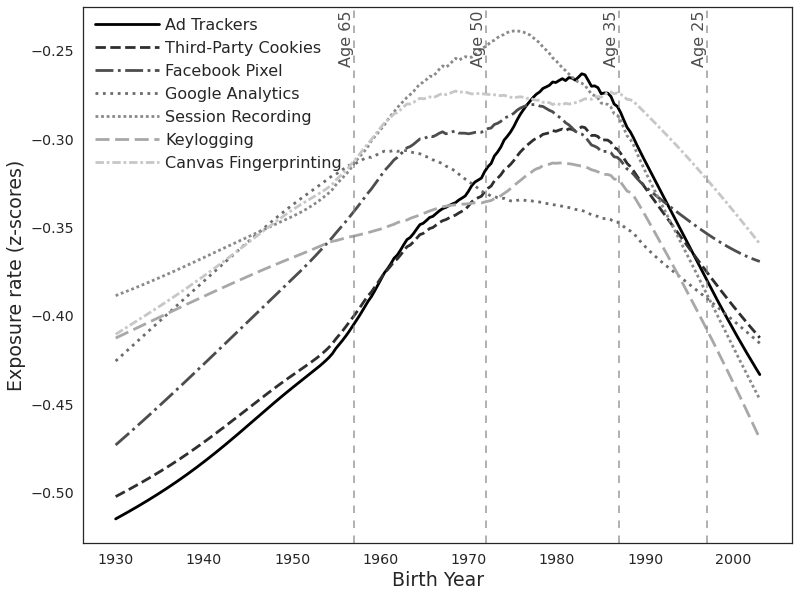

In [21]:
# plot
_scale = .7
_aspect_ratio = (16,12)
figsize = tuple(k * _scale for k in _aspect_ratio)
fig, ax = plt.subplots(figsize=figsize)

# ===============================================================
birthyr_grid = np.linspace(df["birthyr"].min(), df["birthyr"].max(), 200)
ref_ages = [25, 35, 50, 65]
ref_birthyrs = [2022 - age for age in ref_ages]
    
# ===============================================================
for ix, var in enumerate(bl_measures):
    df_plot = df.copy()

    # Winsorize
    low, high = df_plot[var].quantile([0.0, 0.95])
    df_plot[var] = df_plot[var].clip(lower=low, upper=high)

    # z-standardise
    df_plot[var] = (df_plot[var] - df_plot[var].mean()) / df_plot[var].std()

    # LOWESS
    smoothed = lowess(
        endog=df_plot[var],
        exog=df_plot["birthyr"],
        frac=0.5,
        it=3,
        delta=0.0,
        xvals=birthyr_grid,
    )

    ax.plot(
        birthyr_grid,
        smoothed,
        label=var_labels[var],
        linewidth=2.8,
        linestyle=linestyles7[ix],
        color=palette7[ix],
    )

# ===============================================================
# Reference vertical lines for ages
for birthyr, age in zip(ref_birthyrs, ref_ages):
    ax.axvline(x=birthyr, linestyle= (0, (5, 5)), color=".5", alpha=0.8)
    ax.text(
        x=birthyr,
        y=ax.get_ylim()[1] - 0.002,
        s=f"Age {age}",
        rotation=90,
        verticalalignment="top",
        horizontalalignment="right",
        fontsize=16,
        color=".3",
    )

# ===============================================================
# Legend formatting
ax.legend(
    title="",
#     title_fontsize=15,
    fontsize=16,
    loc="upper left",
    frameon=False,
    borderpad=0.2,
    handlelength=4,
    handletextpad=0.4,
)

# ===============================================================
LABEL_SIZE = 19
ax.set_xlabel("Birth Year", fontsize=LABEL_SIZE)
ax.set_ylabel("Exposure rate (z-scores)", fontsize=LABEL_SIZE)

plt.grid(axis="both", visible=False)

plt.tight_layout()
save_mpl_fig("../figures/lowess_age_bl")

## Correlation

In [22]:
x = [
    #  'tt_visits',
    #  'tt_domains',
    "bl_ddg_join_ads_rate",
    "bl_third_party_cookies_rate",
    "bl_fb_pixel_rate",
    "bl_google_analytics_rate",
    "bl_session_recording_rate",
    "bl_key_logging_rate",
    "bl_canvas_fingerprinting_rate",
    "who_trackers_per_page_load_rate",
    "who_tracking_requests_per_page_load_rate",
    #  'who_trackers_requests_all_requests_rate',
    #  'who_data_saved_rate',
    "who_advertising_rate",
    "who_audio_video_player_rate",
    "who_customer_interaction_rate",
    "who_hosting_rate",
    "who_consent_management_rate",
    "who_site_analytics_rate",
    "who_misc_rate",
    "who_utilities_rate",
    "who_social_media_rate",
    "who_adult_advertising_rate",
]
x

['bl_ddg_join_ads_rate',
 'bl_third_party_cookies_rate',
 'bl_fb_pixel_rate',
 'bl_google_analytics_rate',
 'bl_session_recording_rate',
 'bl_key_logging_rate',
 'bl_canvas_fingerprinting_rate',
 'who_trackers_per_page_load_rate',
 'who_tracking_requests_per_page_load_rate',
 'who_advertising_rate',
 'who_audio_video_player_rate',
 'who_customer_interaction_rate',
 'who_hosting_rate',
 'who_consent_management_rate',
 'who_site_analytics_rate',
 'who_misc_rate',
 'who_utilities_rate',
 'who_social_media_rate',
 'who_adult_advertising_rate']

In [23]:
updated_var_labels = {
    k: (
        f"{v} (BL)"
        if k.startswith("bl_")
        else f"{v} (WTM)"
        if k.startswith("who_")
        else v
    )
    for k, v in var_labels.items()
}

df_corr_ = (
    df.select_columns(x).corr().rename(index=updated_var_labels, columns=var_labels)
)
df_corr_

,Ad Trackers,Third-Party Cookies,Facebook Pixel,Google Analytics,Session Recording,Keylogging,Canvas Fingerprinting,Trackers/Page Load,Tracking Requests/Page Load,Advertising,Audio/Video Player,Customer Interaction,Hosting Services,Consent Management,Site Analytics,Miscellaneous,Utilities,Social Media,Adult Advertising
Ad Trackers (BL),1.000000,0.955861,0.707825,0.366199,0.326382,0.449451,0.532712,0.823983,0.746386,0.869577,0.757946,0.772756,0.700731,0.765377,0.820015,0.502075,0.636137,0.747719,0.130440
Third-Party Cookies (BL),0.955861,1.000000,0.578514,0.308468,0.271091,0.384863,0.452836,0.787476,0.732024,0.851634,0.752086,0.773848,0.679195,0.698371,0.773564,0.549905,0.551296,0.749017,0.120212
Facebook Pixel (BL),0.707825,0.578514,1.000000,0.517395,0.488536,0.444775,0.405789,0.589812,0.489181,0.572941,0.491123,0.527331,0.465541,0.591874,0.618894,0.244053,0.549028,0.479373,0.137145
Google Analytics (BL),0.366199,0.308468,0.517395,1.000000,0.291827,0.153975,0.288820,0.330464,0.355576,0.321921,0.203607,0.284312,0.238294,0.392434,0.367634,0.173143,0.344243,0.238928,0.029995
Session Recording (BL),0.326382,0.271091,0.488536,0.291827,1.000000,0.328366,0.352435,0.338242,0.259663,0.276433,0.224401,0.303258,0.309038,0.331720,0.391287,0.113621,0.438859,0.283460,0.146365
Keylogging (BL),0.449451,0.384863,0.444775,0.153975,0.328366,1.000000,0.273992,0.374069,0.285318,0.389376,0.322729,0.284108,0.321910,0.402191,0.418383,0.159954,0.311216,0.318809,0.067525
Canvas Fingerprinting (BL),0.532712,0.452836,0.405789,0.288820,0.352435,0.273992,1.000000,0.475704,0.408601,0.438810,0.408683,0.544483,0.473932,0.427811,0.479285,0.468327,0.523201,0.393897,0.079049
Trackers/Page Load (WTM),0.823983,0.787476,0.589812,0.330464,0.338242,0.374069,0.475704,1.000000,0.841358,0.940184,0.905927,0.834194,0.905050,0.853363,0.941946,0.621425,0.764284,0.920947,0.148864
Tracking Requests/Page Load (WTM),0.746386,0.732024,0.489181,0.355576,0.259663,0.285318,0.408601,0.841358,1.000000,0.851977,0.736030,0.766793,0.727839,0.756869,0.839445,0.570011,0.640828,0.777216,0.132144
Advertising (WTM),0.869577,0.851634,0.572941,0.321921,0.276433,0.389376,0.438810,0.940184,0.851977,1.000000,0.838587,0.830205,0.790900,0.870776,0.938840,0.538193,0.722937,0.853704,0.145601


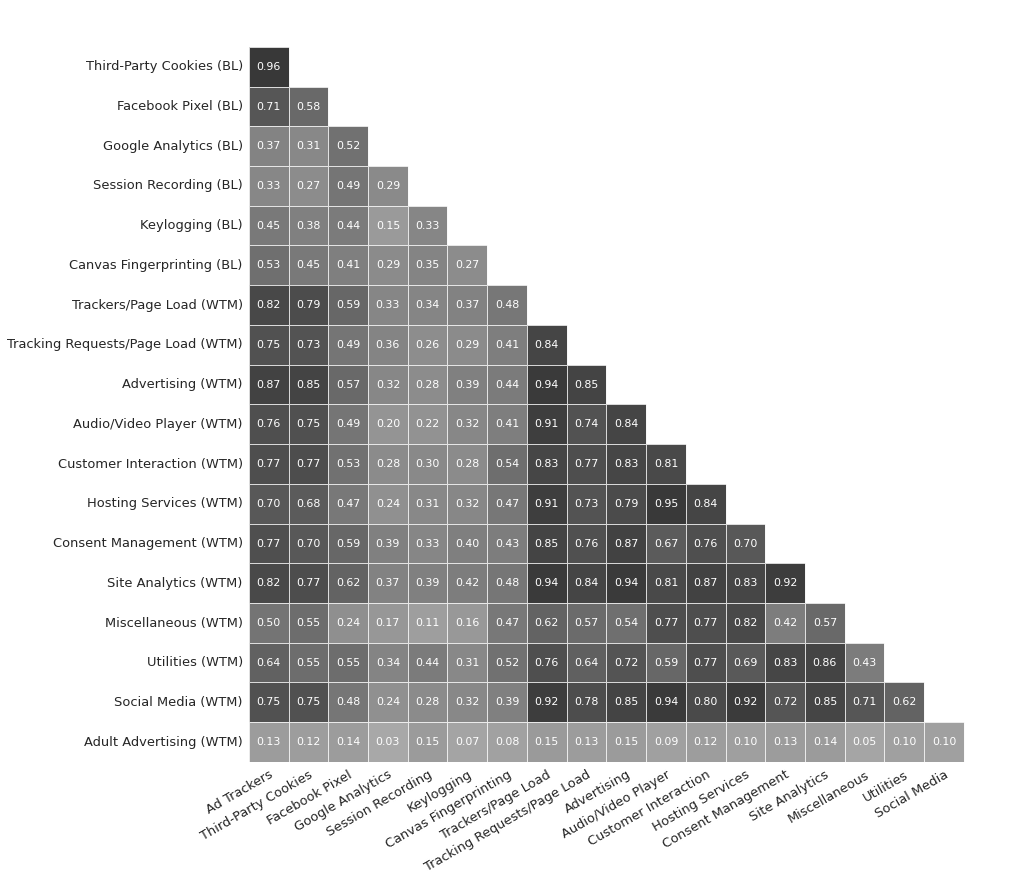

In [24]:
# plot correlations
_scale = 1
_aspect_ratio = (14, 14)
figsize = tuple(k * _scale for k in _aspect_ratio)
fig, ax = plt.subplots(figsize=figsize)

# Heatmap without colorbar for now
sns.heatmap(
    df_corr_,
    # remove upper tri
    mask=np.triu(np.ones_like(df_corr_, dtype=bool)),
    cmap="Greys",
    alpha=0.8,
    vmin=-1,
    vmax=1,
    center=0,
    square=True,
    linewidths=0.5,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 11},
    cbar=False,
    ax=ax,
)

# ===============================================================
# # Cbar
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# # Prep axis
# cax = inset_axes(
#     ax,
#     width="5%",
#     height="40%",
#     loc='upper right',
#     bbox_to_anchor=(
#         -0.15,  # x offset
#          -0.1,  # y offs
#          1,     # width scaling: leave it at 100% of parent box (not used here)
#          1      # height scaling: same as above
#     ),
#     # relative position
#     bbox_transform=ax.transAxes,
#     borderpad=0,
# )

# # Add colorbar
# norm = plt.Normalize(vmin=-1, vmax=1)
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# cbar = fig.colorbar(sm, cax=cax, orientation="vertical")
# cbar.set_label("Correlation", fontsize=11)
# cbar.ax.tick_params(labelsize=9)

# ===============================================================
yticklabels = ax.get_yticklabels()
# remove first redundant label
yticklabels[0] = ""
ax.set_yticklabels(yticklabels)

xticklabels = [label.get_text() for label in ax.get_xticklabels()]
# remove last redundant label
xticklabels[-1] = ""
ax.set_xticklabels(xticklabels, rotation=30, ha="right", rotation_mode="anchor")

ax.tick_params(axis="both", labelsize=13, pad=0)

plt.tight_layout()
save_mpl_fig("../figures/bl_wtm_correlation")